In [1]:
# Load Imagenet
import vit_prisma
from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT
import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt




In [3]:

# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
model = HookedViT.from_pretrained("vit_base_patch32_224",
                                        center_writing_weights=True,
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                        use_attn_result= False,
                                    )

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


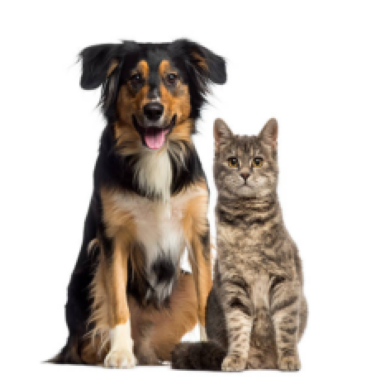

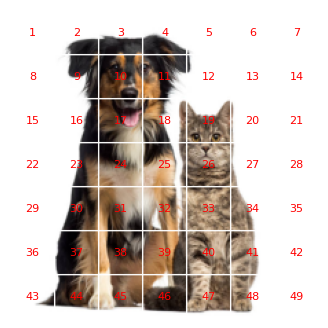

In [2]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])


# Open and display the downloaded image
image = Image.open('cat_dog.jpeg')
image = transform(image)

plot_image(image)

from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

In [5]:
# Path to your imagenet_class.json file
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Create 500 random samples from the ImageNet dataset
# num_samples = 500
# random_indices = np.random.choice(len(imagenet_data), num_samples, replace=False)

# Save the order of these indices
# np.save('imagenet_sample_indices.npy', random_indices)

# Function to load images based on saved order
def load_images_in_order(indices_path, imagenet_dataset):
    indices = np.load(indices_path)
    subset_dataset = Subset(imagenet_dataset, indices)
    data_loader = DataLoader(subset_dataset, batch_size=1)
    return data_loader

# Example of how to use the function
# data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)


# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
# data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)

dataloader = DataLoader(imagenet_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [12]:
from vit_prisma.utils.data_utils.imagenet_emoji import IMAGENET_EMOJI
from vit_prisma.visualization.patch_level_logit_lens import display_patch_logit_lens
from vit_prisma.visualization.patch_level_logit_lens import display_grid_on_image_with_heatmap

from vit_prisma.prisma_tools.logit_lens import get_patch_logit_directions, get_patch_logit_dictionary


all_answers = model.tokens_to_residual_directions(np.arange(1000))


In [15]:

save_base_dir = '/network/scratch/s/sonia.joseph/emoji_logit_lens_images'

html_dir = os.path.join(save_base_dir, "html")
svg_dir = os.path.join(save_base_dir, "svg")
orig_image_dir = os.path.join(save_base_dir, "orig_image")

# Create the directories if they do not exist
os.makedirs(html_dir, exist_ok=True)
os.makedirs(svg_dir, exist_ok=True)
os.makedirs(orig_image_dir, exist_ok=True)

In [6]:
# iterate through 3 imagenet images
from tqdm.auto import tqdm



MAX = 200
for i, (inputs, labels) in tqdm(enumerate(dataloader)):
    if i == MAX:
        break
    # plot_image(inputs[0])
    output, cache = model.run_with_cache(inputs)

    patch_logit_directions = get_patch_logit_directions(cache, all_answers, incl_mid=False)

    patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0)


    fig = display_grid_on_image_with_heatmap(inputs[0], patch_dictionary, alpha_color=.3, emoji_font_size=29, layer_idx=-2, return_graph=True, heatmap_mode='emoji_colors')
    # fig.show()

    # Save as HTML with Plotly
    html_filename = f"figure_{i}.html"
    fig.write_html(os.path.join(html_dir, html_filename))
    # Note: For actual HTML compression, you might use external libraries or manually minify the HTML.
    
    # Save as SVG with Plotly
    svg_filename = f"figure_{i}.svg"
    fig.write_image(os.path.join(svg_dir, svg_filename), format='svg')
    
    # Save original image
    transform_to_pil = transforms.ToPILImage()
    original_image = transform_to_pil(inputs[0])
    img_filename = f"original_image_{i}.png"
    original_image.save(os.path.join(orig_image_dir, img_filename))




0it [00:00, ?it/s]

In [13]:
fig.show()

In [9]:
fig.write_image("plotly_figure.svg", format='svg')


In [22]:
saving_transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    # transforms.CenterCrop(224),  # Crop the images to 224x224 from the center
    # transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
    # Resize to 224
    transforms.Resize((224, 224)),
])

In [9]:
!wget https://www.petpact.com/wp-content/uploads/2017/06/Toilet-training-for-cats.jpg -O toilet_cat.jpg > /dev/null 2>&1
!wget https://pbs.twimg.com/media/CAdWskHVIAEiLL_.jpg:large -O child_lion.jpg > /dev/null 2>&1
!wget https://www.shutterstock.com/image-photo/cheetah-hunting-springbuck-etosha-national-600nw-1034657560.jpg -O cheetah.jpg > /dev/null 2>&1


In [23]:
images = ['cat_dog.jpeg', 'child_lion.jpg', 'cheetah.jpg', 'cat_dog.jpeg']



from IPython.display import display, HTML, IFrame

# Path to your HTML file
# html_file_path = '/network/scratch/s/sonia.joseph/emoji_logit_lens_images/html/figure_0.html'


heatmap_type = 'emoji_colors'
i = 0
for j, file_name in enumerate(images):

    name = file_name.split('.')[0]

    pil_image = Image.open(file_name)
    image = transform(pil_image)
    output, cache = model.run_with_cache(image.unsqueeze(0))

    patch_logit_directions = get_patch_logit_directions(cache, all_answers, incl_mid=False)

    patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0)


    fig = display_grid_on_image_with_heatmap(image, patch_dictionary, alpha_color=.3, emoji_font_size=29, layer_idx=-2, return_graph=True, heatmap_mode=heatmap_type)
    # fig.show()

    # Save as HTML with Plotly
    html_filename = f"{file_name}_{i}_{j}.html"
    fig.write_html(os.path.join(html_dir, html_filename))
    # Note: For actual HTML compression, you might use external libraries or manually minify the HTML.

    # Save as SVG with Plotly
    svg_filename = f"{file_name}_{i}_{j}.svg"
    fig.write_image(os.path.join(svg_dir, svg_filename), format='svg')

    # # Save original image
    # transform_to_pil = transforms.ToPILImage()
    # original_image = transform_to_pil(inputs[0])
    img_filename = f"original_image_{i}_{j}.png"
    pil_image = saving_transform(pil_image)
    pil_image.save(os.path.join(orig_image_dir, f'{name}.jpg'))

